# Bayes by Backprop

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tfk.layers 
tfd = tfp.distributions
tfpl = tfp.layers

print("Tensorflow Version: %s" % tf.__version__)
print("Tensorflow Probability Version: %s" % tfp.__version__)

if tf.test.gpu_device_name() != '/device:GPU:0':
    print('GPU device not found. Using CPU')
else:
    print('Found GPU: {}'.format(tf.test.gpu_device_name()))

Tensorflow Version: 2.0.0-beta1
Tensorflow Probability Version: 0.8.0-dev20190619
Found GPU: /device:GPU:0


In [109]:
# commons package
import os
import sys
import importlib

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import commons as cm
importlib.reload(cm)

<module 'commons' from 'D:\\Tom\\Documents\\gitworkspace\\master\\ml-probability\\tfp_word_embeddings\\commons.py'>

# Configuration and Parameters

In [108]:
# GloVe Configuration

# Directory containing the GloVe files.
GLOVE_DIR = "D:/google drive/haw/master/mastertheisis/hauptprojekt"

# Embedding dimension
EMBEDDING_DIM = 50

In [93]:
setup = cm.setup(glove_dir=GLOVE_DIR, embedding_dim=EMBEDDING_DIM)
(x_train, x_train_padded, y_train) = setup["train"]
(x_test, x_test_padded, y_test) = setup["test"]
word_index = setup["word_index"]

Found 400000 word vectors.
17361/88587 unknown words


In [102]:
# Bayes by Backprop parameters

# variational layer implementation 
variational_layer, variational_layer_name = [
    (tfpl.DenseFlipout, "DenseFlipout"),
    (tfpl.DenseReparameterization, "DenseReparameterization")
][0]

# hidden layers where each element denotes the number of neurons
n_hidden = [64, 64, 32]

# descriptive model name
model_name = "bayes_by_backprop_%s__%s" % (variational_layer_name, "_".join(map(str, n_hidden)))

# model save file
model_save_file = "./models/%s.h5" % model_name

# history save file
history_save_file = "./history/%s.csv" % model_name

# number of data points
N = x_train.shape[0]

# batch size for training
batch_size = 128

# training epochs 
epochs = 20

# validation split
validation_split = 0.05

# History

In [107]:
(history_df, last_epoch) = cm.load_history_from_file(history_save_file=history_save_file)

Loaded history successfully. Last epoch: 20


# Model

In [96]:
# https://github.com/tensorflow/probability/issues/282

def kernel_divergence_fn(q, p, _):
    return tfd.kl_divergence(q, p) / tf.cast(N * (1 - validation_split), tf.float32)

def create_model():
    model = tfk.Sequential(name="model_%s" % model_name)
    
    model.add(setup["embedding_layer"])
    for i in range(len(n_hidden)):
        model.add(variational_layer(n_hidden[i],
                                    activation='relu',
                                    kernel_divergence_fn=kernel_divergence_fn))
    model.add(tfkl.Flatten())
    model.add(variational_layer(1, activation="sigmoid", kernel_divergence_fn=kernel_divergence_fn))
    
    model.compile(optimizer=tfk.optimizers.Adam(0.001), 
                  loss=tfk.losses.binary_crossentropy, 
                  metrics=cm.metrics)
    
    return model

try:
    model = create_model()
    model.load_weights(model_save_file)
    
    # https://github.com/tensorflow/probability/issues/325
    # model = tfk.models.load_model(model_save_file)
    print("using saved model")
except IOError:
    model = create_model()
    print("model has not been trained (IOError)")

model.summary()

model has not been trained (IOError)
Model: "model_bayes_by_backpropv2_DenseFlipout__64_64_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 2697, 50)          4429400   
_________________________________________________________________
dense_flipout_8 (DenseFlipou (None, 2697, 64)          6464      
_________________________________________________________________
dense_flipout_9 (DenseFlipou (None, 2697, 64)          8256      
_________________________________________________________________
dense_flipout_10 (DenseFlipo (None, 2697, 32)          4128      
_________________________________________________________________
flatten_2 (Flatten)          (None, 86304)             0         
_________________________________________________________________
dense_flipout_11 (DenseFlipo (None, 1)                 172609    
Total params: 4,620,857
Trainable params: 191,4

In [98]:
model.fit(x_train_padded, 
          y_train, 
          validation_split=validation_split,
          initial_epoch=last_epoch,
          epochs=epochs, 
          batch_size=batch_size,
          callbacks=cm.get_keras_callbacks(model_save_file=model_save_file, history_save_file=history_save_file))

W0620 22:59:37.505082 10692 deprecation.py:323] From C:\Users\Tom\Anaconda3\envs\mltf2\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 23750 samples, validate on 1250 samples
23750/23750 [==============================] - 35s 1ms/sample - loss: 10.7646 - acc: 0.5063 - true_negatives: 6273.0000 - false_negatives: 6124.0000 - true_positives: 5752.0000 - false_positives: 5601.0000 - precision: 0.5067 - recall: 0.4843 - kl: 0.3913 - val_loss: 10.4571 - val_acc: 0.5192 - val_true_negatives: 428.0000 - val_false_negatives: 403.0000 - val_true_positives: 221.0000 - val_false_positives: 198.0000 - val_precision: 0.5274 - val_recall: 0.3542 - val_kl: 0.3717


In [14]:
loss, accuracy, *other = model.evaluate(x_test_padded, y_test)
print("Test loss: %.2f\nTest accuracy: %.2f%%" % (loss, accuracy * 100))

25000/25000 [==============================] - 32s 1ms/sample - loss: 1.7932 - acc: 0.8292 - true_negatives: 10095.0000 - false_negatives: 1866.0000 - true_positives: 10634.0000 - false_positives: 2405.0000 - precision: 0.8156 - recall: 0.8507 - kl: 0.1912
Test loss: 1.79
Test accuracy: 82.92%


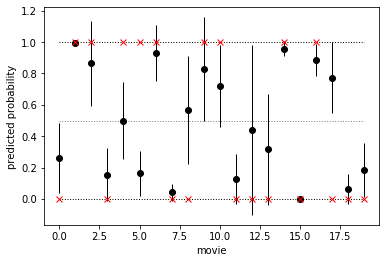

In [79]:
n = 20
samples = 75

y_pred = [model.predict(x_test_padded[:n]) for i in range(samples)]
y_pred = np.array(y_pred)

means = [np.mean(y_pred[:, i]) for i in range(n)]
stddevs = [np.std(y_pred[:, i]) for i in range(n)]
cm.plot_confidence(means, stddevs, y_test[:n])

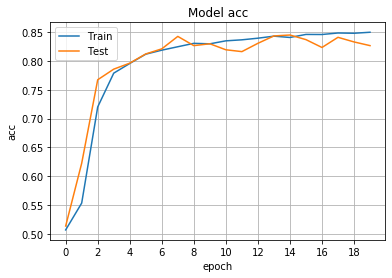

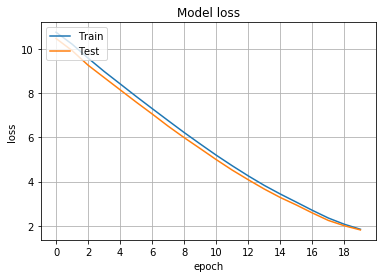

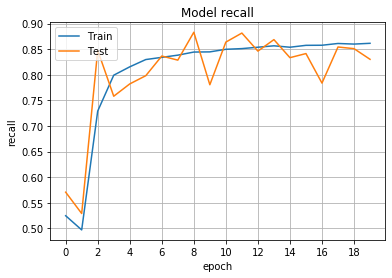

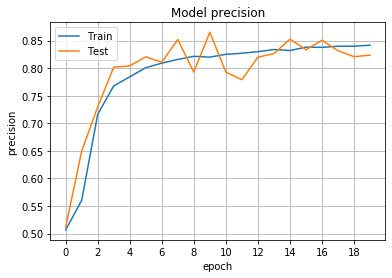

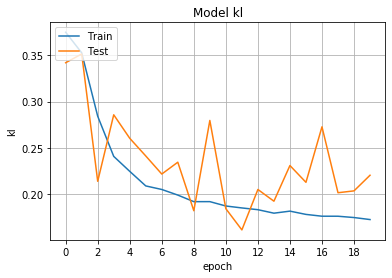

In [78]:
for metric in ["acc", "loss", "recall", "precision", "kl"] :
    cm.plot_metric(metric, history_df)
    plt.show()